# Setup
The code below is only needed if you are running the demo in colab. It installs a package to stream content on Google Colab.

**Note:** Make sure you have GPU enabled if you are running in colab.

Select Runtime > Change runtime type > Hardware accelerator: GPU


In [2]:
# VirtualHome 코드 수정 시 바로 반영하는 코드
%load_ext autoreload
%autoreload 2

In [3]:
import os
if 'google.colab' in str(get_ipython()):  # colab에서 돌릴 때만 필요한 코드. 실제 코랩에서 실행했을 때 requirements 설치에서 에러남
    print('Running on CoLab')
    osname = "linux"
    !pip install git+https://github.com/xavierpuigf/colabstreamer
    import colabstreamer
    colabstreamer.config_all()
    _xorg = colabstreamer.open_xorg()
    # Clone VirtualHome
    !git clone https://github.com/xavierpuigf/virtualhome.git
    %cd /content/virtualhome
    !pip install -r requirements.txt
else:   # local에서 할 때
    from sys import platform
    if platform == "darwin":
        osname = "macos"
    elif platform == "linux":
        osname = "linux"
    elif platform == "windows" or platform == 'win32':
        osname = "windows"

In [4]:
%cd demo

[WinError 2] 지정된 파일을 찾을 수 없습니다: 'demo'
C:\Users\ACSL\Desktop\JW\virtualhome-master\virtualhome-master\virtualhome\demo


In [5]:
%pwd

'C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\demo'

# Imports

In [6]:
%matplotlib notebook
import IPython.display
import glob
from utils_demo import *
import pandas as pd
from sys import platform
import sys
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import shutil
import virtualhome
from unity_simulator.comm_unity import UnityCommunication
from unity_simulator import utils_viz

# Starting communication

The first step is to start a communication with the simulator. Make sure before you run this that you have downloaded the simulator, and placed it under the `simulation` folder. You will be interacting with the simulator with the communication `comm` created here. You can include the file name of the simulator or just call `UnityCommunication()` and manually open the executable.

Select `manual` if you are opening the executable separately, and `auto` if the unity executable is still not open.

Remember that if you are running this in a headless server, you will need to start a display in a separate terminal using:

```
sudo python helper_scripts/startx $DISPLAY_NUM
```

This is not needed if you are running a colab notebook.

In [7]:
mode = 'manual' # auto / manual -> 실행파일을 따로 열었으면 manual.
if mode == 'auto':
    if platform == 'darwin':
        exec_file = '../macos_exec*'
    else:
        exec_file = '../linux_exec*.x86_64'
    file_names = glob.glob(exec_file)
    if len(file_names) > 0:
        file_name = file_names[0]
        comm = UnityCommunication(file_name=file_name, port="8082", x_display="0")
    else:
        print("Error: executable path not found.")
else:
    comm = UnityCommunication()

In [8]:
comm.reset(40)

True

# Starting and Visualizing Scenes (동작 확인용)

After initalizing the simulation. We can interact with the environments provided in VirtualHome. The simulator is composed of 50 human designed apartments, a sample of environments can be seen here.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


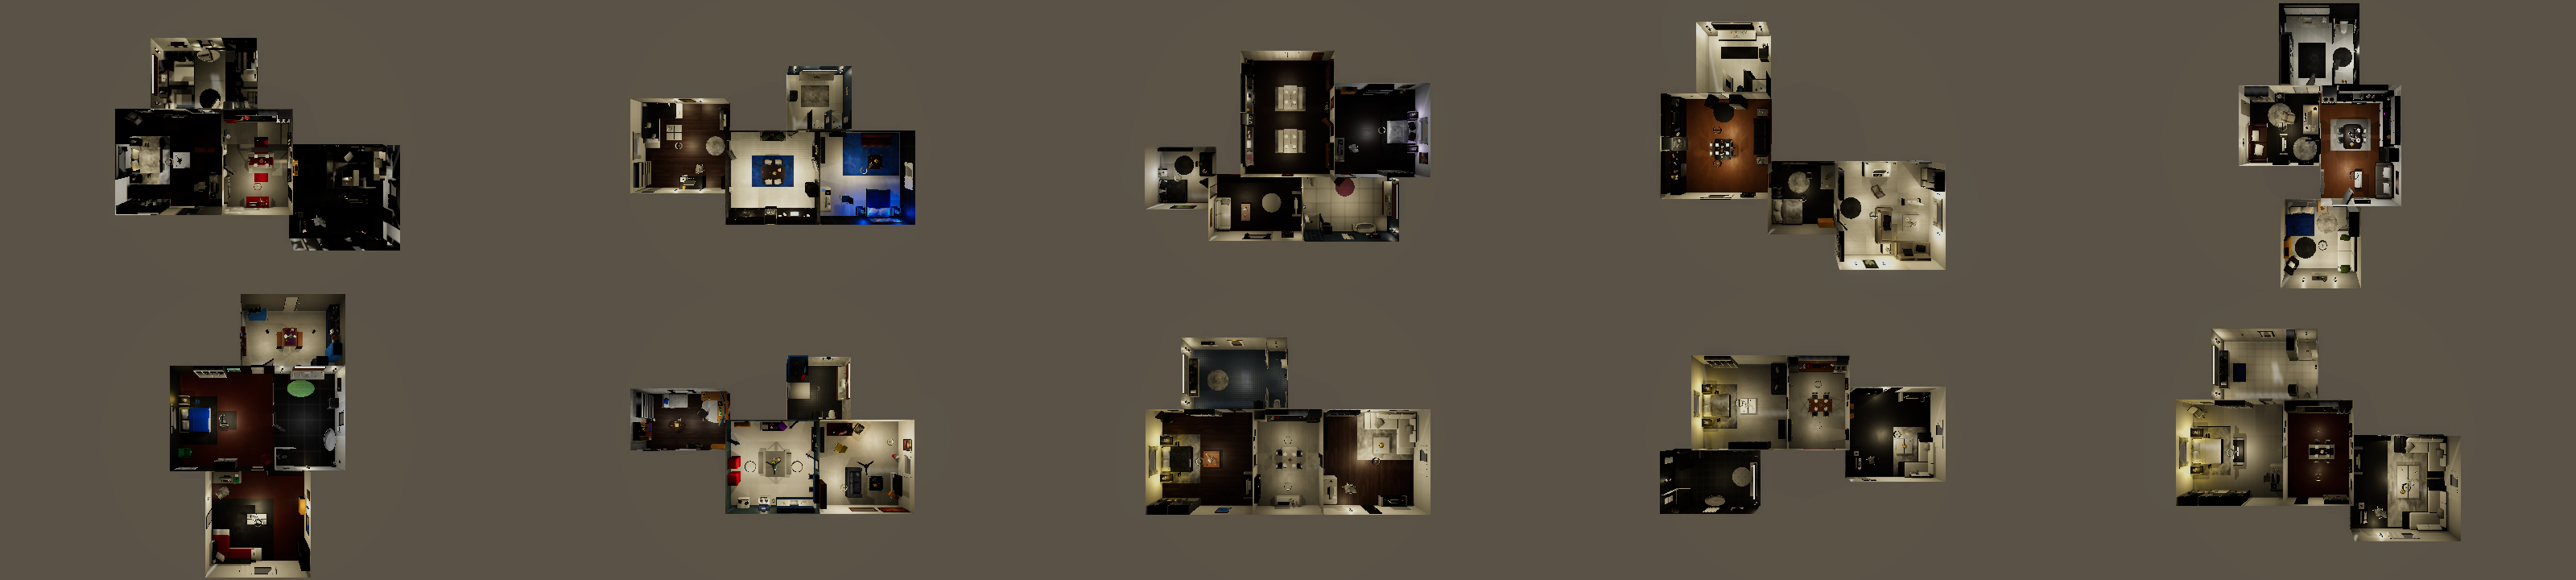

In [9]:
# The environments are numbered 0 to 50, let's visualize a few
views = []
for scene_id in tqdm(range(10)):
    comm.reset(scene_id)  #

    # We will go over the line below later
    comm.remove_terrain()
    top_view = get_scene_cameras(comm, [-1])
    views += top_view

IPython.display.display(display_grid_img(views, nrows=2))

# Procedural Generation (scene 다양화시 필요한 코드. 위 50개 scene에 대해 데이터 생성이 완료되고 난 후. 당장은 필요하지 않음)

VirtualHome also has support for procedural generation where we can generate completely new environments during runtime.

In [10]:
def set_action(who, action, object1=[], object2=[])->str:
    if len(object2)==0 and len(object1)!=0:
        return '<char{}> [{}] <{}> ({})'.format(str(who), str(action), str(object1[0]), str(object1[1]))
    elif len(object2)!=0 and len(object1)!=0:
        return '<char{}> [{}] <{}> ({}) <{}> ({})'.format(str(who), str(action), str(object1[0]), str(object1[1]), str(object2[0]), str(object2[1]))
    elif len(object2)==0 and len(object1)==0:
        return '<char{}> [{}]'.format(str(who), str(action))


In [23]:

import cv2
import numpy as np
import glob

import time

import os

def images_to_video(image_folder, video_name, fps=24):
    images = [img for img in os.listdir(image_folder) if img.endswith("normal.png")]
    images.sort()  # 파일명 순으로 정렬

    if not images:
        print("No PNG images found in the specified folder.")
        return

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    print(frame.shape)
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        img_path = os.path.join(image_folder, image)
        frame = cv2.imread(img_path)
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()

def play_video(video_path):
    instance = cv2.VideoCapture(video_path)

    while True:
        ret, frame = instance.read()
        if not ret:
            break

        cv2.imshow('Video', frame)

        # 1ms마다 키 입력을 확인
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    instance.release()
    cv2.destroyAllWindows()

from openpyxl import load_workbook

wb = load_workbook("C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\graphs\\output.xlsx")

# Iterate over all worksheets in the workbook
for ws in wb.worksheets:
    def findExistString(searchString, text):
        if searchString in text:
            return True
        else:
            return False
    def findObExistString(searchString1, text1, searchString2, text2):
        if searchString1 in text1 and searchString2 in text2:
            return True
        else:
            return False


def setting(num, one, two, who): 
    s, g = comm.environment_graph()
    with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\graphs\\graph_' + str(num) + '.json', 'w') as f:
      json.dump(g, f, indent=4)

    # Add agents
    # 첫번째 agent는 로봇이라 가정하고 안보이는 agent로 세팅. 두번째 agent가 실제로 동작을 수행
    comm.add_character_camera(position=[0, 1.8, 0.15], rotation=[20, 0, 0], name='new_camera')
    comm.add_character('Chars/Male1_invisible', initial_room='{}'.format(one))
    comm.add_character('Chars/{}'.format(who), initial_room='{}'.format(two))
    bathroom1_id=11
    bathroom2_id=54
    bedroom_id=97
    kitchen_id=168
    livingroom_id=340
    
    return bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id

# Generating Scripts (Multi-agent Actions)

The last step is to perform activities in them. We do this by defining scripts: Lists of instructions that will be executed in sequence. Each instruction contains an action, an object, and an id. The id should match with the `id` of each of the nodes in the environment graph.

We now want to execute the script in the environment. We do that through **render_script**. Notice that we can specify a file name, which will be used to save a video with the activity.

Other paramters to render_script are:
- script: a list of script lines
- randomize_execution: randomly choose elements
- random_seed: random seed to use when randomizing execution, -1 means that the seed is not set
- find_solution: find solution (True) or use graph ids to determine object instances (False)
- processing_time_limit: time limit for finding a solution
- skip_execution: skip rendering, only check if a solution exists
- output_folder: folder to output renderings, default is Output/
- file_name_prefix: prefix of created files (screenshots are put to output_folder/file_name_prefix/)
- frame_rate: frame rate
- capture_screenshot: save screenshots
- image_synthesis: save depth, segmentation, flow images
- save_pose_data: save pose data
- save_scene_states: save scene states
- character_resource: path to character resource to be used
- camera_mode: automatic (AUTO), first person (FIRST_PERSON), top (PERSON_TOP), front person view (PERSON_FRONT)

In [34]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(222, 'kitchen', 'livingroom', 'Female4')
  
num=0 #장면 번호
script = [
    
    set_action(0, "walk", ["bathroom", bathroom2_id]),
    set_action(0, "walk", ["curtains", 70]),
    set_action(0, "walktowards", ["bathroomcounter", 72]),
    set_action(1, "walk", ["bathroom", bathroom2_id]),
    set_action(1, "walk", ["bathroomcounter", 72]),
    set_action(1, "grab", ["barsoap", 77]),
    set_action(1, "putback", ["barsoap", 77], ["sink", 73]),
    set_action(1, "switchon", ["faucet", 74]),
    set_action(1, "run", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bathroom1_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bathroom> (54)
<char0> [walk] <curtains> (70)
<char0> [walktowards] <bathroomcounter> (72)
<char1> [walk] <bathroom> (54)
<char1> [walk] <bathroomcounter> (72)
<char1> [grab] <barsoap> (77)
<char1> [putback] <barsoap> (77) <sink> (73)
<char1> [switchon] <faucet> (74)
<char1> [run] <livingroom> (340)
<char0> [walk] <kitchen> (168)
<char0> [walk] <bedroom> (97)
<char0> [walk] <bathroom> (11)
<char0> [walk] <bedroom> (97)
<char0> [walk] <kitchen> (168)
<char0> [walk] <livingroom> (340)


In [35]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [49]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(223, 'kitchen', 'livingroom', 'Male2')
  
num=1 #장면 번호
script = [
    
    set_action(0, "walk", ["bathroom", bathroom2_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bathroom1_id]),
    set_action(0, "walk", ["bathroomcounter", 34]),
    set_action(0, "walktowards", ["toilet", 29]),
    set_action(1, "run", ["bathroom", bathroom1_id]),
    set_action(1, "walk", ["toilet", 29]),
    set_action(1, "open", ["toilet", 29]),
    set_action(1, "sit", ["toilet", 29]),
    set_action(1, "standup"),
    set_action(1, "walk", ["toilet", 29]),
    set_action(1, "close", ["toilet", 29]),
    set_action(1, "walk", ["lightswitch", 52]),
    set_action(0, "walktowards", ["lightswitch", 52]),
    set_action(1, "switchoff", ["lightswitch", 52]),
    set_action(1, "walk", ["lightswitch", 52]),
    
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bathroom> (54)
<char0> [walk] <kitchen> (168)
<char0> [walk] <bedroom> (97)
<char0> [walk] <bathroom> (11)
<char0> [walk] <bathroomcounter> (34)
<char0> [walktowards] <toilet> (29)
<char1> [run] <bathroom> (11)
<char1> [walk] <toilet> (29)
<char1> [open] <toilet> (29)
<char1> [sit] <toilet> (29)
<char1> [standup]
<char1> [walk] <toilet> (29)
<char1> [close] <toilet> (29)
<char1> [walk] <lightswitch> (52)
<char0> [walktowards] <lightswitch> (52)
<char1> [switchoff] <lightswitch> (52)
<char1> [walk] <lightswitch> (52)
<char0> [walk] <bedroom> (97)
<char0> [walk] <kitchen> (168)
<char0> [walk] <kitchen> (168)


In [50]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [51]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(224, 'bedroom', 'livingroom', 'Male2')
  
num=2 #장면 번호
script = [
    
    set_action(0, "walk", ["bathroom", bathroom1_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bathroom", bathroom2_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["desk", 391]),
    set_action(0, "walktowards", ["tv", 428]),
    set_action(1, "walk", ["tv", 428]),
    set_action(1, "switchon", ["tv", 428]),
    set_action(1, "walk", ["coffeetable", 394]),
    set_action(1, "grab", ["apple", 397]),
    set_action(1, "walk", ["sofa", 395]),
    set_action(1, "sit", ["sofa", 395]),

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bathroom> (11)
<char0> [walk] <bedroom> (97)
<char0> [walk] <kitchen> (168)
<char0> [walk] <bathroom> (54)
<char0> [walk] <kitchen> (168)
<char0> [walk] <livingroom> (340)
<char0> [walk] <desk> (391)
<char0> [walktowards] <tv> (428)
<char1> [walk] <tv> (428)
<char1> [switchon] <tv> (428)
<char1> [walk] <coffeetable> (394)
<char1> [grab] <apple> (397)
<char1> [walk] <sofa> (395)
<char1> [sit] <sofa> (395)


In [52]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [58]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(225, 'bedroom', 'livingroom', 'Male2')
  
num=3 #장면 번호
script = [
    
    set_action(0, "walk", ["bathroom", bathroom1_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bathroom", bathroom2_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["closet", 383]),
    set_action(0, "walktowards", ["desk", 391]),
    set_action(1, "walk", ["desk", 391]),
    set_action(1, "grab", ["mouse", 426]),
    set_action(1, "walk", ["bookshelf", 393]),
    set_action(1, "putin", ["mouse", 426], ["bookshelf", 393]),
    set_action(1, "grab", ["book", 419]),
    set_action(1, "read", ["book", 419]),

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bathroom> (11)
<char0> [walk] <bedroom> (97)
<char0> [walk] <kitchen> (168)
<char0> [walk] <bathroom> (54)
<char0> [walk] <kitchen> (168)
<char0> [walk] <livingroom> (340)
<char0> [walk] <closet> (383)
<char0> [walktowards] <desk> (391)
<char1> [walk] <desk> (391)
<char1> [grab] <mouse> (426)
<char1> [walk] <bookshelf> (393)
<char1> [putin] <mouse> (426) <bookshelf> (393)
<char1> [grab] <book> (419)
<char1> [read] <book> (419)


In [59]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [69]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(226, 'bedroom', 'livingroom', 'Male2')
  
num=4 #장면 번호
script = [
    
    set_action(0, "walk", ["bathroom", bathroom1_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bathroom", bathroom2_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["closet", 383]),
    set_action(0, "walktowards", ["desk", 391]),
    set_action(1, "walk", ["bookshelf", 393]),
    set_action(1, "grab", ["book", 419]),
    set_action(1, "walk", ["sofa", 395]),
    set_action(0, "walk", ["bookshelf", 393]),
    set_action(0, "walktowards", ["coffeetable", 394]),
    set_action(1, "sit", ["sofa", 395]),
    set_action(1, "read", ["book", 419]),
    set_action(1, "standup"),
    set_action(1, "putback", ["book", 419], ["coffeetable", 394]),

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bathroom> (11)
<char0> [walk] <bedroom> (97)
<char0> [walk] <kitchen> (168)
<char0> [walk] <bathroom> (54)
<char0> [walk] <kitchen> (168)
<char0> [walk] <livingroom> (340)
<char0> [walk] <closet> (383)
<char0> [walktowards] <desk> (391)
<char1> [walk] <bookshelf> (393)
<char1> [grab] <book> (419)
<char1> [walk] <sofa> (395)
<char0> [walk] <bookshelf> (393)
<char0> [walktowards] <coffeetable> (394)
<char1> [sit] <sofa> (395)
<char1> [read] <book> (419)
<char1> [standup]
<char1> [putback] <book> (419) <coffeetable> (394)


In [70]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [88]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(227, 'livingroom', 'bedroom', 'Male1')
  
num=5 #장면 번호
script = [
    
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["closet", 283]),
    set_action(0, "walktowards", ["kitchentable", 259]),
    set_action(1, "walk", ["kitchen", kitchen_id]),
    set_action(1, "walk", ["kitchentable", 259]),
    set_action(1, "grab", ["poundcake", 313]),
    set_action(1, "walk", ["stove", 291]),
    set_action(0, "walktowards", ["stove", 291]),
    set_action(1, "putback", ["poundcake", 313], ["stove", 291]),
    set_action(1, "switchon", ["stove", 291]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bathroom1_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bathroom", bathroom2_id]),



]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <kitchen> (168)
<char0> [walk] <closet> (283)
<char0> [walktowards] <kitchentable> (259)
<char1> [walk] <kitchen> (168)
<char1> [walk] <kitchentable> (259)
<char1> [grab] <poundcake> (313)
<char1> [walk] <stove> (291)
<char0> [walktowards] <stove> (291)
<char1> [putback] <poundcake> (313) <stove> (291)
<char1> [switchon] <stove> (291)
<char0> [walk] <bedroom> (97)
<char0> [walk] <bathroom> (11)
<char0> [walk] <bedroom> (97)
<char0> [walk] <kitchen> (168)
<char0> [walk] <livingroom> (340)
<char0> [walk] <bathroom> (54)


In [89]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [96]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(228, 'livingroom', 'bedroom', 'Male1')
  
num=6 #장면 번호
script = [
    
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["closet", 283]),
    set_action(0, "walktowards", ["kitchentable", 259]),
    set_action(1, "walk", ["kitchen", kitchen_id]),
    set_action(1, "walk", ["kitchentable", 259]),
    set_action(1, "grab", ["apple", 314]),
    set_action(1, "walk", ["sink", 274]),
    set_action(1, "putback", ["apple", 314], ["sink", 274]),
    set_action(1, "switchon", ["faucet", 275]),
    set_action(1, "switchoff", ["faucet", 275]),
    set_action(1, "grab", ["apple", 314]),
    set_action(1, "walk", ["fridge", 299]),
    set_action(0, "walk", ["closet", 283]),
    set_action(0, "walktowards", ["fridge", 299]),
    set_action(1, "open", ["fridge", 299]),
    set_action(1, "putin",["apple", 314], ["fridge", 299]),
    set_action(1, "close", ["fridge", 299]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bathroom1_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bathroom", bathroom2_id]),



]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <kitchen> (168)
<char0> [walk] <closet> (283)
<char0> [walktowards] <kitchentable> (259)
<char1> [walk] <kitchen> (168)
<char1> [walk] <kitchentable> (259)
<char1> [grab] <apple> (314)
<char1> [walk] <sink> (274)
<char1> [putback] <apple> (314) <sink> (274)
<char1> [switchon] <faucet> (275)
<char1> [switchoff] <faucet> (275)
<char1> [grab] <apple> (314)
<char1> [walk] <fridge> (299)
<char0> [walk] <closet> (283)
<char0> [walktowards] <fridge> (299)
<char1> [open] <fridge> (299)
<char1> [putin] <apple> (314) <fridge> (299)
<char1> [close] <fridge> (299)
<char0> [walk] <bedroom> (97)
<char0> [walk] <bathroom> (11)
<char0> [walk] <bedroom> (97)
<char0> [walk] <kitchen> (168)
<char0> [walk] <livingroom> (340)
<char0> [walk] <bathroom> (54)


In [97]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [107]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(229, 'livingroom', 'bedroom', 'Male1')
  
num=7 #장면 번호
script = [
    
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["kitchencounter", 265]),
    set_action(0, "walktowards", ["bookshelf", 277]),
    set_action(1, "walk", ["kitchen", kitchen_id]),
    set_action(1, "walk", ["bookshelf", 277]),
    set_action(1, "grab", ["alcohol", 334]),
    set_action(1, "drink", ["alcohol", 334]),
    set_action(1, "grab", ["chips", 329]),
    set_action(1, "drink", ["chips", 329]),
    set_action(1, "run", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bathroom1_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bathroom", bathroom2_id]),



]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <kitchen> (168)
<char0> [walk] <kitchencounter> (265)
<char0> [walktowards] <bookshelf> (277)
<char1> [walk] <kitchen> (168)
<char1> [walk] <bookshelf> (277)
<char1> [grab] <alcohol> (334)
<char1> [drink] <alcohol> (334)
<char1> [grab] <chips> (329)
<char1> [drink] <chips> (329)
<char1> [run] <livingroom> (340)
<char0> [walk] <bedroom> (97)
<char0> [walk] <bathroom> (11)
<char0> [walk] <bedroom> (97)
<char0> [walk] <kitchen> (168)
<char0> [walk] <livingroom> (340)
<char0> [walk] <bathroom> (54)


In [108]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [111]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(230, 'kitchen', 'bathroom', 'Female2')
  
num=8 #장면 번호
script = [
    


    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bathroom", bathroom2_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),   
    set_action(0, "walk", ["bedroom", bedroom_id]),   
    set_action(0, "walk", ["bookshelf", 119]),   
    set_action(0, "walktowards", ["desk", 128]),   
    set_action(1, "run", ["bedroom", bedroom_id]), 
    set_action(1, "walk", ["desk", 128]),
    set_action(1, "switchon", ["computer", 138]),
    set_action(1, "walk", ["pillow", 154]),
    set_action(1, "grab", ["pillow", 154]),
    set_action(1, "walk", ["lightswitch", 144]),
    set_action(1, "switchoff", ["lightswitch", 144]),
    set_action(1, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bathroom", bathroom1_id]),


]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <livingroom> (340)
<char0> [walk] <bathroom> (54)
<char0> [walk] <livingroom> (340)
<char0> [walk] <kitchen> (168)
<char0> [walk] <bedroom> (97)
<char0> [walk] <bookshelf> (119)
<char0> [walktowards] <desk> (128)
<char1> [run] <bedroom> (97)
<char1> [walk] <desk> (128)
<char1> [switchon] <computer> (138)
<char1> [walk] <pillow> (154)
<char1> [grab] <pillow> (154)
<char1> [walk] <lightswitch> (144)
<char1> [switchoff] <lightswitch> (144)
<char1> [walk] <livingroom> (340)
<char0> [walk] <bathroom> (11)


In [112]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [120]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(44) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom1_id, bathroom2_id, bedroom_id, kitchen_id, livingroom_id )=setting(231, 'kitchen', 'bathroom', 'Female2')
  
num=9 #장면 번호
script = [
    
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bathroom", bathroom2_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),   
    set_action(0, "walk", ["bedroom", bedroom_id]),   
    set_action(0, "walk", ["cabinet", 129]),   
    set_action(0, "walktowards", ["bookshelf", 119]),   
    set_action(1, "run", ["bedroom", bedroom_id]), 
    set_action(1, "walk", ["bookshelf", 119]), 
    set_action(1, "switchon", ["radio", 146]), 
    set_action(1, "grab", ["slippers", 159]), 
    set_action(1, "grab", ["slippers", 160]),
    set_action(1, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bathroom", bathroom1_id]),

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <livingroom> (340)
<char0> [walk] <bathroom> (54)
<char0> [walk] <livingroom> (340)
<char0> [walk] <kitchen> (168)
<char0> [walk] <bedroom> (97)
<char0> [walk] <cabinet> (129)
<char0> [walktowards] <bookshelf> (119)
<char1> [run] <bedroom> (97)
<char1> [walk] <bookshelf> (119)
<char1> [switchon] <radio> (146)
<char1> [grab] <slippers> (159)
<char1> [grab] <slippers> (160)
<char1> [walk] <livingroom> (340)
<char0> [walk] <bathroom> (11)


In [121]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


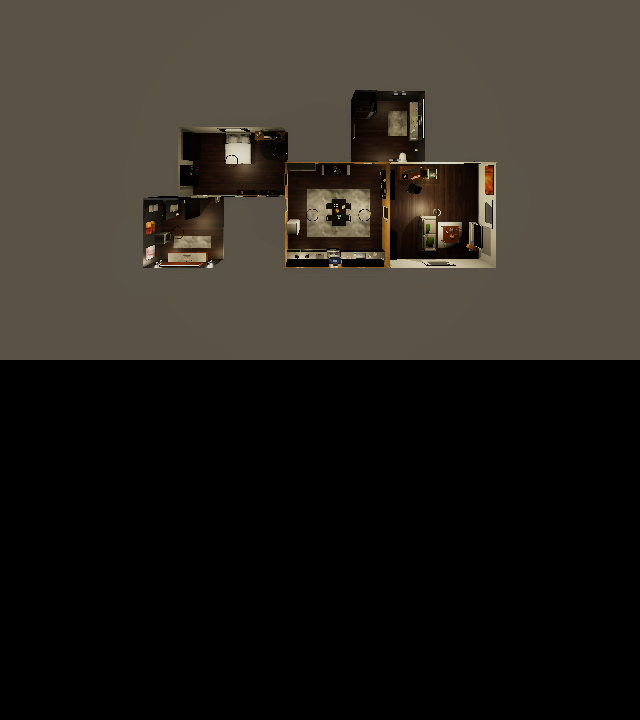

In [12]:
# The environments are numbered 0 to 50, let's visualize a few
views = []
comm.reset(44)  #
comm.remove_terrain()
top_view = get_scene_cameras(comm, [-1])
IPython.display.display(display_grid_img(top_view, nrows=2))

In [100]:
add_list=[]
# Lamps Props Ceiling Windows Walls Floor Appliances Electronics Rooms Furniture Food
for row in ws.iter_rows(): 
        if findObExistString("Furniture", row[1].value, "bedroom", row[7].value): #7 2 5
            fine=str(row[0].value)+" "+str(row[2].value)+" "+str(row[5].value)+" "+str(row[7].value)
            if fine not in add_list:
               add_list.append(fine)
               print(add_list.pop())
        # if findExistString("Rooms", row[1].value): #7 2
        #     print(row[0].value, row[2].value)

119 bookshelf 97 bedroom
120 chair 97 bedroom
121 closet 97 bedroom
122 hanger 97 bedroom
123 clothesshirt 97 bedroom
124 hanger 97 bedroom
125 clothesshirt 97 bedroom
126 hanger 97 bedroom
127 clothespants 97 bedroom
128 desk 97 bedroom
129 cabinet 97 bedroom
130 bed 97 bedroom
131 cabinet 97 bedroom


## (위에서 graph.json을 저장했을 경우) 액션이 끝날 때마다 scene graph 업데이트가 잘 이루어졌는지 확인하는 코드. 내용이 다르다고 하면 잘 업데이트 된 것)

In [18]:
# # 저장된 graph.json 파일들이 서로 같은지 비교하는 코드
# file1_path = '../build_camera/Output/script0/0/graph_2.json'
# file2_path = '../build_camera/Output/script0/0/graph_3.json'

# def compare_files(file1_path, file2_path):
#     with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
#         content1 = file1.read()
#         content2 = file2.read()

#     if content1 == content2:
#         print("두 파일의 내용이 동일합니다.")
#     else:
#         print("두 파일의 내용이 다릅니다.")

# compare_files(file1_path, file2_path)

import json
import os 
import openpyxl                                                                                                                                                                                               
#경로 수정할 것
os.chdir("C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\graphs")


# JSON 파일 로드
with open('graph_222.json', 'r') as f:
    data = json.load(f)

# nodes와 edges 데이터 추출
nodes_data = data['nodes']
edges_data = data['edges']

# nodes 정보를 DataFrame으로 변환
df_nodes = pd.DataFrame(nodes_data)

# 필요한 nodes 컬럼만 선택
df_nodes = df_nodes[['id', 'category', 'class_name', 'prefab_name', 'properties']]

# edges 정보를 DataFrame으로 변환
df_edges = pd.DataFrame(edges_data)                                               

# edges에서 필요한 정보 추출
df_edges = df_edges[['from_id', 'to_id', 'relation_type']]

# 'to_id'에 해당하는 'class_name' 찾기
df_edges['to_class_name'] = df_edges['to_id'].map(df_nodes.set_index('id')['class_name'].to_dict())

# nodes와 edges 데이터 병합
df = pd.merge(df_nodes, df_edges, how='left', left_on='id', right_on='from_id')

# 필요한 column 순서로 재배치
df = df[['id', 'category', 'class_name', 'prefab_name', 'properties', 'to_id', 'relation_type', 'to_class_name']]

# 결과 출력
df.to_excel("output.xlsx", index=False, engine='xlsxwriter')


## Generating videos (생성된 프레임을 비디오로 만들고 싶을 때. 당장 필요한 코드는 아님)

In [ ]:
# Enter here the path to the video, it should be in the same location where you stored your executable
path_video = "../build_linux_camera/Output/"
utils_viz.generate_video(input_path=path_video,
                         prefix='script2',
                         char_id=0,
                         image_synthesis=['normal'],  #depth는 생성 안됨
                         frame_rate=20,
                         output_path=None) # None: output_path = input_path + '/' + prefix

# => 동영상이 중간에 잘리는건 프레임이 중간중간 빠져서!(ex. 103, 175 등. 이유는 모름). 프레임 복사해서 임의로 넣어봄

In [ ]:
display_vid('../build_linux_camera/Output/script1/video_normal.mp4')

In [ ]:
# Enter here the path to the video, it should be in the same location where you stored your executable
path_video = "../build_linux_camera/Output/"
utils_viz.generate_video(input_path=path_video,
                         prefix='script2',
                         char_id=0,
                         image_synthesis=['normal'],  #depth는 생성 안됨
                         frame_rate=20,
                         output_path=None) # None: output_path = input_path + '/' + prefix

# => 동영상이 중간에 잘리는건 프레임이 중간중간 빠져서!(ex. 103, 175 등. 이유는 모름). 프레임 복사해서 임의로 넣어봄

In [ ]:
display_vid('../build_linux_camera/Output/script1/video_normal.mp4')